In [1]:
# PyTorch imports
import torch
from torch import nn
import torch.nn.functional as F
import torchvision as tv
from torchsummary import summary

# Package imports
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

# Standard imports
import random
from datetime import datetime

# Local imports
import ml_tools as ml
import cifar_data_tools as dt

In [2]:
# Load train/test dataset
train_dataset, test_dataset, label_dict = dt.load_CIFAR10_data(verbose=2)

Loading CIFAR dataset...
Files already downloaded and verified
Files already downloaded and verified
  Training data shape: (50000, 32, 32, 3)
  Test data shape: (10000, 32, 32, 3)
  Data min,max values: 0,255
  Data labels (10 categories): 0:Airplane, 1:Automobile, 2:Bird, 3:Cat, 4:Deer, 5:Dog, 6:Frog, 7:Horse, 8:Ship, 9:Truck


{0: 'Airplane', 1: 'Automobile', 2: 'Bird', 3: 'Cat', 4: 'Deer', 5: 'Dog', 6: 'Frog', 7: 'Horse', 8: 'Ship', 9: 'Truck'}


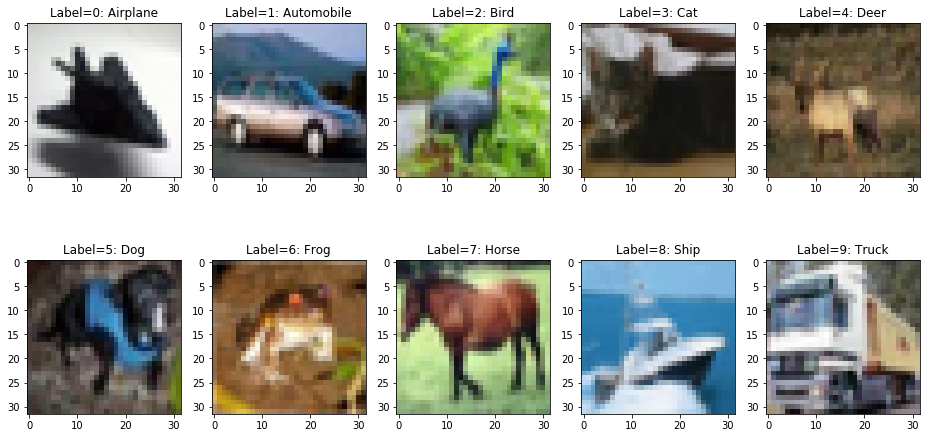

In [3]:
print(label_dict)
# Plot one example image from each category 
dt.display_example_data(train_dataset, label_dict)

In [4]:
# Define model using custom module
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(128 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, K)
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0),-1)
        x = F.dropout(x, p=0.5)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.2)
        x = self.fc2(x)
        return x

model = CNN(len(label_dict))

In [5]:
# Check to see if GPU is available and move model to GPU if it is
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('GPU is available?: {}'.format(torch.cuda.is_available()))
print('Using device: {}'.format(device))
model.to(device)    

GPU is available?: False
Using device: cpu


CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel

In [6]:
# Define our loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [7]:
# Use PyTorch built-in data loader to deal with batch creation and shuffling
#    (for batch gradient descent, because we don't want to load the whole dataset into memory all at once!)\
batch_size = 128
train_loader, test_loader = dt.get_dataloaders(train_dataset, test_dataset, 
                                               batch_size=batch_size)

# Train the model!
train_losses, test_losses = ml.train(train_loader, model, optimizer, criterion,
                                     device=device, n_epochs=40, test_loader=test_loader, 
                                     verbose=1, print_every=1)

Training NN through 40 epochs.  Start time: 2021-02-01 22:56:36.614597


KeyboardInterrupt: 

In [8]:
# Plot the losses
ml.plot_losses(train_losses, test_losses)

NameError: name 'train_losses' is not defined

In [9]:
# Get model predictions
train_predictions, train_targets = ml.predict(train_loader, model, device=device, 
                                              multiclass=True)
test_predictions, test_targets = ml.predict(test_loader, model, device=device, 
                                            multiclass=True)
    
# Get overall accuracy
ml.get_accuracy(train_predictions, train_targets, test_predictions, test_targets)

KeyboardInterrupt: 

In [10]:
ml.plot_confusion_matrix(test_targets, test_predictions, labels=label_dict, log_color=True)

NameError: name 'test_targets' is not defined

In [11]:
# Plot examples of images we got wrong
correct, wrong = ml.get_correct_wrong(test_predictions, test_targets)
print('Examples our model got wrong:')
dt.display_pred_examples(wrong,test_dataset, test_targets, test_predictions,label_dict)

NameError: name 'test_predictions' is not defined

In [12]:
summary(model)

TypeError: summary() missing 1 required positional argument: 'input_size'